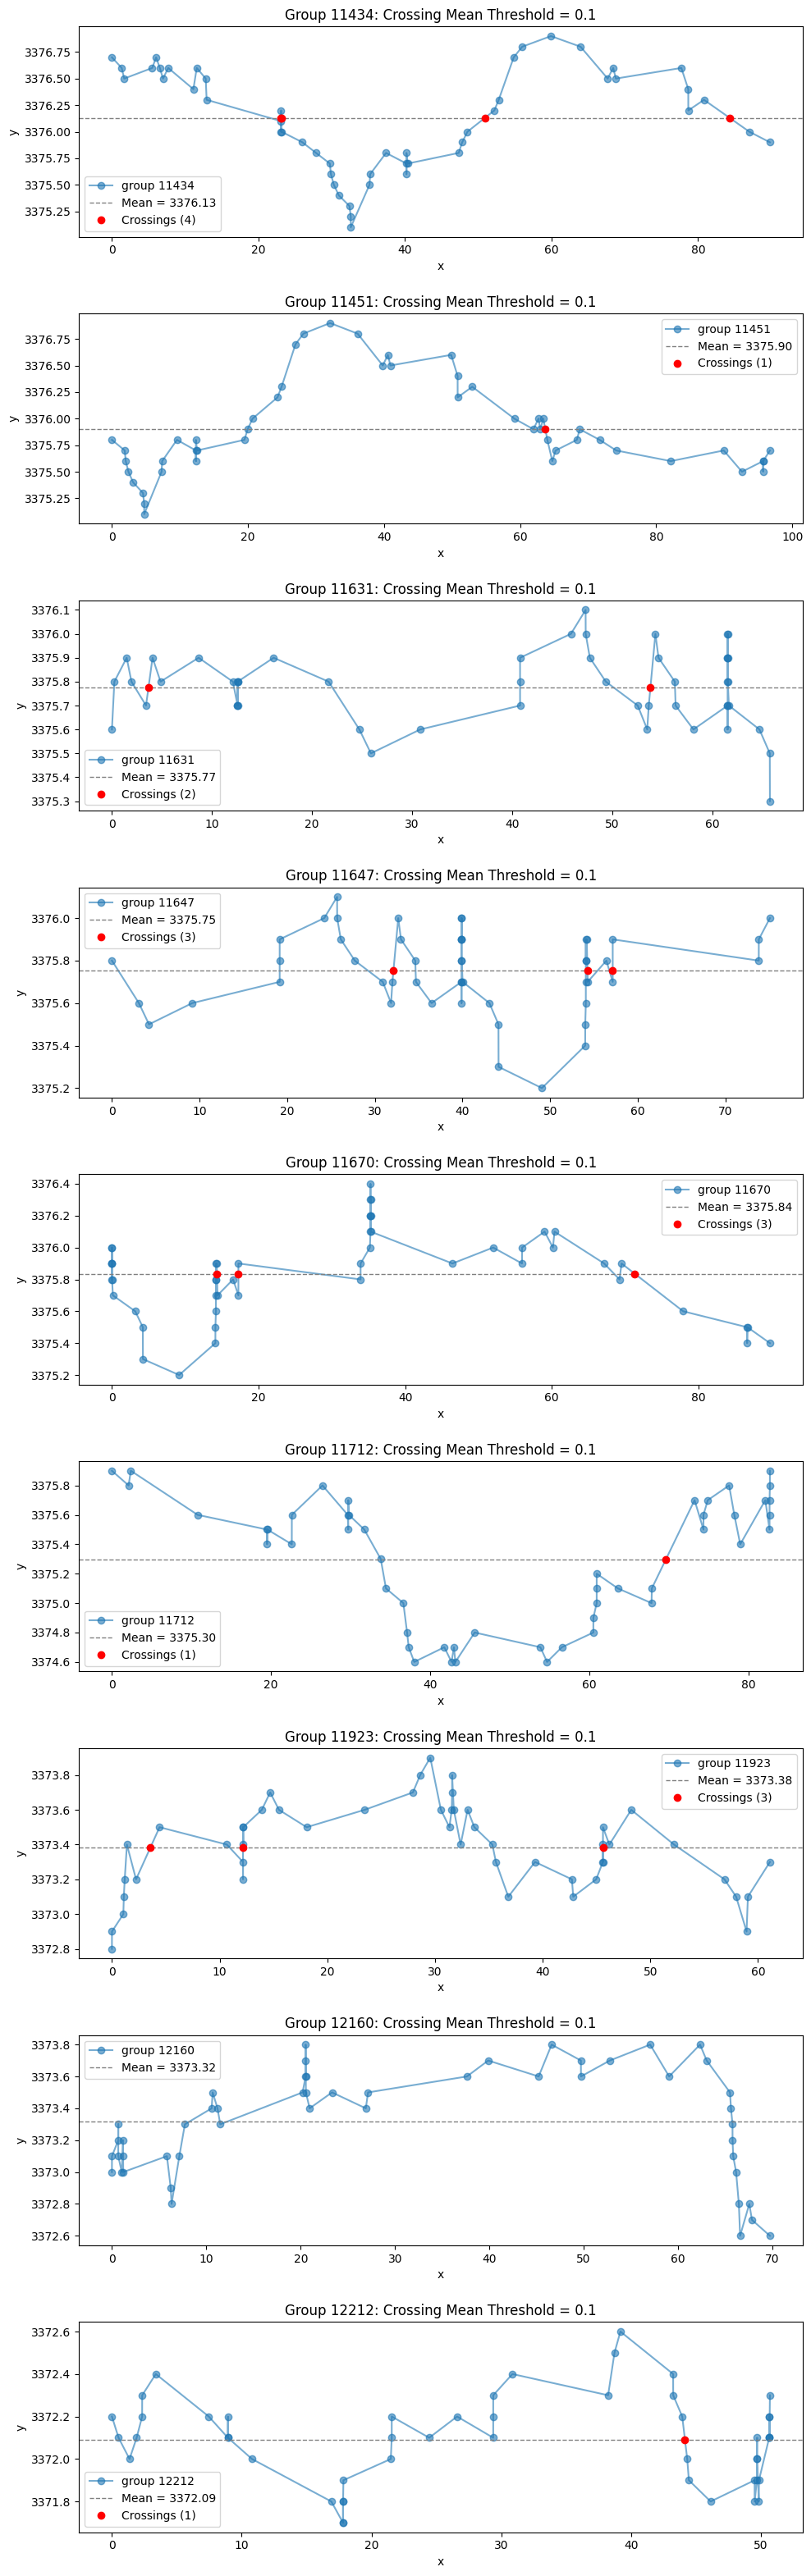

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# # 可选：屏蔽字体警告
# warnings.filterwarnings("ignore")
# plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']  # 可换成你机器支持的中文字体
# plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv("sample.csv")

# 参数
threshold = 0.1  # y值相对变化需超过阈值
groups = df["group"].unique()

def detect_crossings(group_df, threshold):
    """检测有效穿越均值的点，返回交叉点列表"""
    group_df = group_df.sort_values("x")
    y_mean = group_df["y"].mean()
    x_vals = group_df["x"].values
    y_vals = group_df["y"].values

    crossings = []
    for i in range(len(y_vals) - 1):
        y1, y2 = y_vals[i], y_vals[i + 1]
        delta_y = y2 - y1

        # 是否穿越均值方向
        crosses_mean = (y1 - y_mean) * (y2 - y_mean) < 0
        sufficient_change = abs(delta_y) > threshold
        strong_deviation = all(abs(y - y_mean) > threshold / 2 for y in [y1, y2])

        if crosses_mean and sufficient_change and strong_deviation:
            # 线性插值近似交点
            x_cross = x_vals[i] + (x_vals[i + 1] - x_vals[i]) * abs(y1 - y_mean) / abs(delta_y)
            crossings.append((x_cross, y_mean))
    return crossings, y_mean

# 画图
fig, axes = plt.subplots(len(groups), 1, figsize=(10, 3.5 * len(groups)), dpi=100)
if len(groups) == 1:
    axes = [axes]

for ax, group in zip(axes, groups):
    group_df = df[df["group"] == group].copy()
    crossings, y_mean = detect_crossings(group_df, threshold)

    # 折线图
    ax.plot(group_df["x"], group_df["y"], "o-", alpha=0.6, label=f"group {group}")

    # 均值线
    ax.axhline(y_mean, color="gray", linestyle="--", linewidth=1, label=f"Mean = {y_mean:.2f}")

    # 标注穿越点
    if crossings:
        cross_x, cross_y = zip(*crossings)
        ax.plot(cross_x, cross_y, "ro", markersize=6, label=f"Crossings ({len(crossings)})")

    ax.set_title(f"Group {group}: Crossing Mean Threshold = {threshold}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

plt.tight_layout(h_pad=2.0)
plt.show()


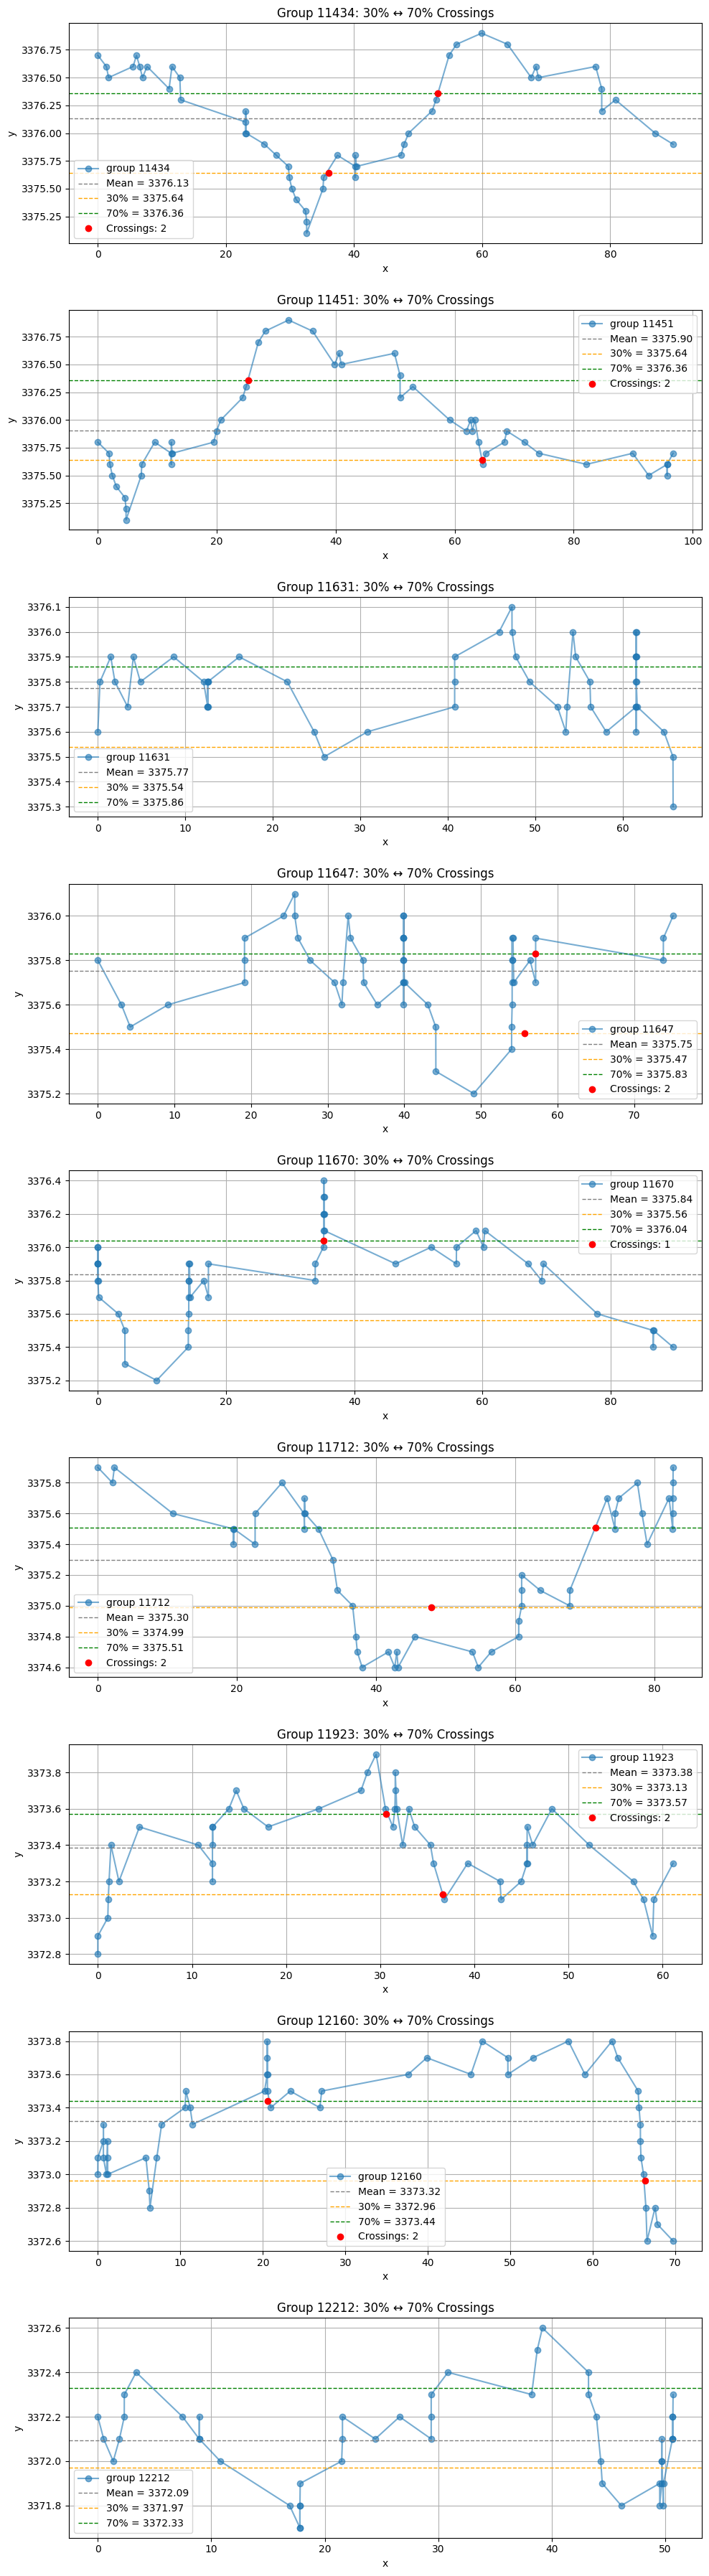

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
with open("sample.csv", "r", encoding="utf-8") as f:
    df = pd.read_csv(f)

# 插值函数（用于求穿越点的精确 x 坐标）
def interpolate_x(y1, y2, x1, x2, y_target):
    if y2 == y1:
        return (x1 + x2) / 2  # 避免除零
    return x1 + (x2 - x1) * (y_target - y1) / (y2 - y1)

# 穿越检测函数：从 above ↔ below 记录 crossing
def detect_crossings(group_df, threshold=0.0):
    if len(group_df) < 2:
        return [], 0, 0, 0

    group_df = group_df.sort_values("x")
    x_vals, y_vals = group_df["x"].values, group_df["y"].values

    y_mean = y_vals.mean()
    y_min, y_max = y_vals.min(), y_vals.max()
    y_30 = y_min + 0.3 * (y_max - y_min)
    y_70 = y_min + 0.7 * (y_max - y_min)

    crossings = []
    state = None
    x_prev, y_prev = None, None

    for x, y in zip(x_vals, y_vals):
        if state is None:
            if y > y_70:
                state = "above"
            elif y < y_30:
                state = "below"
            x_prev, y_prev = x, y
            continue

        # 检测高→低穿越
        if state == "above" and y < y_30 and abs(y - y_prev) > threshold:
            x_cross = interpolate_x(y_prev, y, x_prev, x, y_30)
            crossings.append((x_cross, y_30))
            state = "below"

        # 检测低→高穿越
        elif state == "below" and y > y_70 and abs(y - y_prev) > threshold:
            x_cross = interpolate_x(y_prev, y, x_prev, x, y_70)
            crossings.append((x_cross, y_70))
            state = "above"

        x_prev, y_prev = x, y

    return crossings, y_mean, y_30, y_70


# 开始绘图
groups = df["group"].unique()
fig, axes = plt.subplots(len(groups), 1, figsize=(10, 4 * len(groups)), dpi=100)
if len(groups) == 1:
    axes = [axes]

for ax, group_id in zip(axes, groups):
    group_df = df[df["group"] == group_id]
    crossings, y_mean, y_30, y_70 = detect_crossings(group_df, threshold=0.2)

    # 曲线
    ax.plot(group_df["x"], group_df["y"], "o-", alpha=0.6, label=f"group {group_id}")

    # 水平线：均值、30%、70%
    ax.axhline(y_mean, color="gray", linestyle="--", linewidth=1, label=f"Mean = {y_mean:.2f}")
    ax.axhline(y_30, color="orange", linestyle="--", linewidth=1, label=f"30% = {y_30:.2f}")
    ax.axhline(y_70, color="green", linestyle="--", linewidth=1, label=f"70% = {y_70:.2f}")

    # 穿越点
    if crossings:
        cross_x, cross_y = zip(*crossings)
        ax.plot(cross_x, cross_y, "ro", markersize=6, label=f"Crossings: {len(crossings)}")

    ax.set_title(f"Group {group_id}: 30% ↔ 70% Crossings")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)

plt.tight_layout(h_pad=2.0)
plt.show()
